# GUI Label Tool
>##### Reference:&emsp;曾韋翔仁兄

## Table of Contents
* [1. Import Packages](#1.-Import-Packages)
* [2. Read CSV File](#2.-Read-CSV-File)
* [3. GUI Tool](#3.-GUI-Tool)
* [4. Read label CSV File](#4.-Read-label-CSV-File)
* [5. Check Label Overview](#5.-Check-Label-Overview)
* [6. Threshold Controling](#6.-Threshold-Controling)

## 1. Import Packages
[Go back to the Table of Contents](#Table-of-Contents)

In [1]:
import tkinter as tk
from PIL import Image, ImageTk
import pandas as pd
from tkinter import font as tkFont  # for convenience
import os
import matplotlib.pyplot as plt

## 2. Read CSV File
[Go back to the Table of Contents](#Table-of-Contents)

In [2]:
df_sample = pd.read_csv('./data_result_df.csv')  

In [3]:
# 讀取抽樣樣本清單
df_sample = df_sample[df_sample.blue_color<0.001]
df_sample = df_sample.reset_index(drop = True)

In [4]:
df_sample.head()

,path,blue_color
0,//Srvappweb-t/f$/AA/P2_OK_P4\AB002-AA0769076.jpg,0.000124
1,//Srvappweb-t/f$/AA/P2_OK_P4\AB002-AA0769077.jpg,0.000989
2,//Srvappweb-t/f$/AA/P2_OK_P4\AB002-AA0769078.jpg,0.000040
3,//Srvappweb-t/f$/AA/P2_OK_P4\AB002-AA0816279.jpg,0.000215
4,//Srvappweb-t/f$/AA/P2_OK_P4\AB002-AA0842141.jpg,0.000532


In [5]:
print(f'we need to label: {len(df_sample)} image')

we need to label: 11668 image


In [6]:
# 建立結果紀錄檔，篩選尚未貼標的清單
label_log_file = './blue_check_0.001_white_Error.csv'  # 檔名
if not os.path.exists(label_log_file):  # 判斷是否存在，不存在才建立
    df = pd.DataFrame(columns=['path', 'blue_color', 'human_check'])
    df.to_csv(label_log_file, index=False)
else:  #  如果檔案存在(貼標過)
    df_res = pd.read_csv(label_log_file)  # 讀取資料
    for i in range(len(df_res)):  # 結合 df_sample 篩選尚未做過的照片
        if df_res.iloc[i]['path'] in df_sample['path'].tolist():
            df_sample = df_sample[df_sample.path != df_res.iloc[i]['path']]

## 3. GUI Tool
[Go back to the Table of Contents](#Table-of-Contents)

In [7]:
mode = 'complete_pic'  # P2: 右下編號   P1_1: 左下logo  P1_2: 整張照片

def update_data():  # 更新介面中的圖片、文字
    text = f"{root.x+1}/{len(df_sample)}, {root.fname.split('/')[-1]}"  # 文字內容："照片編號/清單長度, 檔名"
    vlabel.configure(image=root.img)  # 更新圖片
    bot_path.configure(text=text)  # 更新文字

    
def image_processing():  # 圖片讀取+處理
    root.fname = df_sample.iloc[root.x]['path']  # 取得檔名
    img = Image.open(root.fname)  # 讀取照片
    img_y = 750  # 設定照片大小調整之預設高度
    
    if mode == 'P2':  # 只看右下角 編號
        img_y = 450  # 設定照片大小調整之預設高度
        width, height = img.size  # 取得圖片長寬
        left, top, right, bottom = (width//2)+(width//8), (height//2)+(int(height//2.7)), width, height  # 計算裁切範圍
        img = img.crop((left, top, right, bottom))  # 裁切照片
    elif mode == 'P1_1':  # 只看左下角 logo
        img_y = 400
        width, height = img.size 
        left, top, right, bottom = 0, 9*height/10, 1*width/3, height 
        img = img.crop((left, top, right, bottom)) 


    width, height = img.size  # 取得圖片長寬
    img = img.resize((int((img_y/img.size[1])*img.size[0]),img_y),Image.ANTIALIAS)  # 調整圖片大小
    root.img = ImageTk.PhotoImage(img)  # 轉換照片for GUI
    
    
def save_and_next(identify):  # 紀錄貼標結果 + 換照片
    human_check = pd.read_csv(label_log_file)  # 讀取貼標紀錄檔
    if root.fname in human_check['path'].tolist():  # 判斷是否重新貼標
        human_check = human_check[human_check.path != root.fname]  # 刪除舊資料
        human_check.to_csv(label_log_file, index=False)  # 儲存
    res = [df_sample.iloc[root.x].tolist() + [identify]]  # 新的貼標紀錄
    df = pd.DataFrame(res)  # 轉換DF
    df.to_csv(label_log_file, index=False, header=False, mode='a')  # 寫入紀錄檔
    root.x += 1  # 換下一張
    
    try:
        image_processing()  # 圖片讀取+處理
        update_data()  # 圖片更新
    except IndexError as er:  # 全部判斷完了!!
        print(er)
        bot_path.configure(text="Finished!!" ) 
    
    
def Button_NG():  # 按鈕觸發之程式
    save_and_next('NG')
    
    
def Button_OK():  # 按鈕觸發之程式
    save_and_next('OK')

    
def Button_ERROR():  # 按鈕觸發之程式
    save_and_next('ERROR')
    
    
def next_page():  # 換下一張(不做貼標處理)
    root.x += 1  # 取得下一張的index
    
    if root.x <= len(df_sample):
        image_processing()  # 圖片讀取+處理
        update_data()  # 圖片更新
    else:  # 如果沒有下一張了
        bot_path.configure(text="NO DATA!!!" )
    
    
def last_page():  # 換上一張(不做貼標處理)
    root.x -= 1 
    
    if root.x >= 0:
        image_processing() 
        update_data() 
    else:  # 如果沒有上一張了
        bot_path.configure(text="NO DATA!!!" )

        
def xFunc1(event):
    if event.keycode == 39:
        next_page()
    elif event.keycode == 37:
        last_page()
    elif event.keycode == 49:
        Button_OK()
    elif event.keycode == 50:
        Button_NG()
    elif event.keycode == 51:
        Button_ERROR()
        
root = tk.Tk()  # GUI主檔
root.title("Label Tool")  # 視窗標題
root.configure(background='white')  # 設定視窗背景顏色
root.x = 0  # 紀錄照片清單順序
root.geometry("1100x980")  # 設定視窗大小

# 判斷照片呈現模式，調整物件位置參數、視窗大小
rel_y = 0.90  # 按鈕位置設定

if mode == 'P2':  # 看編號
    root.geometry("1200x650")  # 設定視窗大小
elif mode == 'P1_1':  # 看logo
    root.geometry("1200x580")
else:  # 看整張
    root.geometry("1100x940")
    rel_y = 0.93
    
# 圖片
image_processing()  # 取得第一張照片
vlabel=tk.Label(root,image=root.img)  # 上傳至GUI
vlabel.configure(background='white')  # 背景顏色
vlabel.focus_set()
vlabel.pack(side = "top")  # 圖片位置
vlabel.bind("<Key>", xFunc1)

# 檔名
text = f"{root.x+1}/{len(df_sample)}, {root.fname.split('/')[-1]}"  # 文字內容："照片編號/清單長度, 檔名"
bot_path = tk.Label(root, text=text, font=("Arial", 35))  # 文字呈現視窗、內容、格式
bot_path.configure(background='white')  # 背景顏色
bot_path.pack(side = "top")  # 文字位置

# 按鈕格式設定值
helv = tkFont.Font(family='Helvetica', size=30, weight='bold')  # 標籤按鈕文字格式
helv_change = tkFont.Font(family='Helvetica', size=25, weight='bold')  # 換張按鈕文字格式
font_color = '#3b3b3b'  # 文字顏色
bg_ok, bg_ng, bg_err = '#d7fcac', '#ffba59', '#ff5c59'  # 標籤按鈕顏色
bg_next, bg_last = '#ffffff', '#ffffff'  # 換張按鈕顏色
pad = (10, 10)  # 邊界大小

# 標籤按鈕
height, width = 1, 10  # 按鈕長寬

# 建立按鈕物件   所屬框架   文字       觸發程式          背景顏色   高度           寬度         文字格式    文字顏色
P1_OK = tk.Button(root, text="OK", command=Button_OK, bg=bg_ok, height=height, width=width, font=helv, fg=font_color)
P1_OK.place(relx=0.25, rely=rel_y, anchor=tk.CENTER)  # 按鈕位置

P1_NG = tk.Button(root, text="NG", command=Button_NG, bg=bg_ng, height=height, width=width, font=helv, fg=font_color)
P1_NG.place(relx=0.5, rely=rel_y, anchor=tk.CENTER)

P1_ERROR = tk.Button(root, text="ERROR", command=Button_ERROR, bg=bg_err, height=height, width=width, font=helv, fg=font_color)
P1_ERROR.place(relx=0.75, rely=rel_y, anchor=tk.CENTER)

# 換張按鈕
height, width = 2, 5  # 按鈕長寬

# 建立按鈕物件          所屬框架  文字        觸發程式          背景顏色    按鈕樣式(平化)    高度           寬度         文字格式
next_button = tk.Button(root, text=">>>", command=next_page, bg=bg_next, relief='flat',height=height, width=width, font=helv)
next_button.pack(side=tk.RIGHT, padx = pad, pady = pad)  # 按鈕位置

last_button = tk.Button(root, text="<<<", command=last_page, bg=bg_last, relief='flat',height=height, width=width, font=helv)
last_button.pack(side=tk.LEFT, padx = pad, pady = pad)

root.mainloop()  # 啟動 GUI

## 4. Read label CSV File
[Go back to the Table of Contents](#Table-of-Contents)

In [8]:
blue_check_df = pd.read_csv('./blue_check_0.001.csv')  

In [9]:
blue_check_df.head()

,path,blue_color,human_check
0,//Srvappweb-t/f$/AA/P2_OK_P4\AB002-AA0769076.jpg,0.000124,OK
1,//Srvappweb-t/f$/AA/P2_OK_P4\AB002-AA0769077.jpg,0.000989,OK
2,//Srvappweb-t/f$/AA/P2_OK_P4\AB002-AA0769078.jpg,0.000040,OK
3,//Srvappweb-t/f$/AA/P2_OK_P4\AB002-AA0816279.jpg,0.000215,OK
4,//Srvappweb-t/f$/AA/P2_OK_P4\AB002-AA0842141.jpg,0.000532,OK


## 5. Check Label Overview
[Go back to the Table of Contents](#Table-of-Contents)

In [10]:
blue_check_df.groupby(['human_check']).size()

human_check
ERROR      491
NG         187
OK       10989
dtype: int64

In [11]:
print(f'{len(blue_check_df)} image we already label')

11667

## 6. Threshold Controling
[Go back to the Table of Contents](#Table-of-Contents)

In [12]:
blue_check_df_rank = blue_check_df.sort_values('blue_color')
blue_check_df_rank = blue_check_df_rank.reset_index(drop = True)

In [13]:
blue_check_df_rank['ranks'] = [i for i in range(len(blue_check_df_rank))]

In [14]:
blue_check_df_rank['error_count'] = [(blue_check_df_rank.human_check[0:i+1]=='ERROR').sum() for i in range(len(blue_check_df_rank))]

In [15]:
blue_check_df_rank['ok_count'] = [(blue_check_df_rank.human_check[0:i+1]=='OK').sum() for i in range(len(blue_check_df_rank))]

In [16]:
blue_check_df_rank['ng_count'] = [(blue_check_df_rank.human_check[0:i+1]=='NG').sum() for i in range(len(blue_check_df_rank))]

In [17]:
blue_check_df_rank

,path,blue_color,human_check,ranks,error_count,ok_count,ng_count
0,//Srvappweb-t/f$/UG/P3_OK_P4\XC052-UG0760014.jpg,0.000000,OK,0,0,1,0
1,//Srvappweb-t/f$/EG/P2_OK_P4\NB014-EG0140941.jpg,0.000000,OK,1,0,2,0
2,//Srvappweb-t/f$/EG/P2_OK_P4\NB014-EG0140945.jpg,0.000000,OK,2,0,3,0
3,//Srvappweb-t/f$/EG/P2_OK_P4\NB014-EG0140950.jpg,0.000000,OK,3,0,4,0
4,//Srvappweb-t/f$/EG/P2_OK_P4\NB014-EG0156552.jpg,0.000000,OK,4,0,5,0
...,...,...,...,...,...,...,...
11662,//Srvappweb-t/f$/AG/P2_OK_P4\DC060-AG1096827.jpg,0.000999,OK,11662,490,10986,187
11663,//Srvappweb-t/f$/AG/P2_OK_P4\DC060-AG1096946.jpg,0.000999,OK,11663,490,10987,187
11664,//Srvappweb-t/f$/EG/P2_OK_P4\PC100-EG0229458.jpg,0.000999,ERROR,11664,491,10987,187
11665,//Srvappweb-t/f$/UD/P2_OK_P4\UB128-UD0731505.jpg,0.000999,OK,11665,491,10988,187


In [31]:
x = blue_check_df_rank.blue_color	
error_count = blue_check_df_rank.error_count
ok_count = blue_check_df_rank.ok_count
ng_count = blue_check_df_rank.ng_count

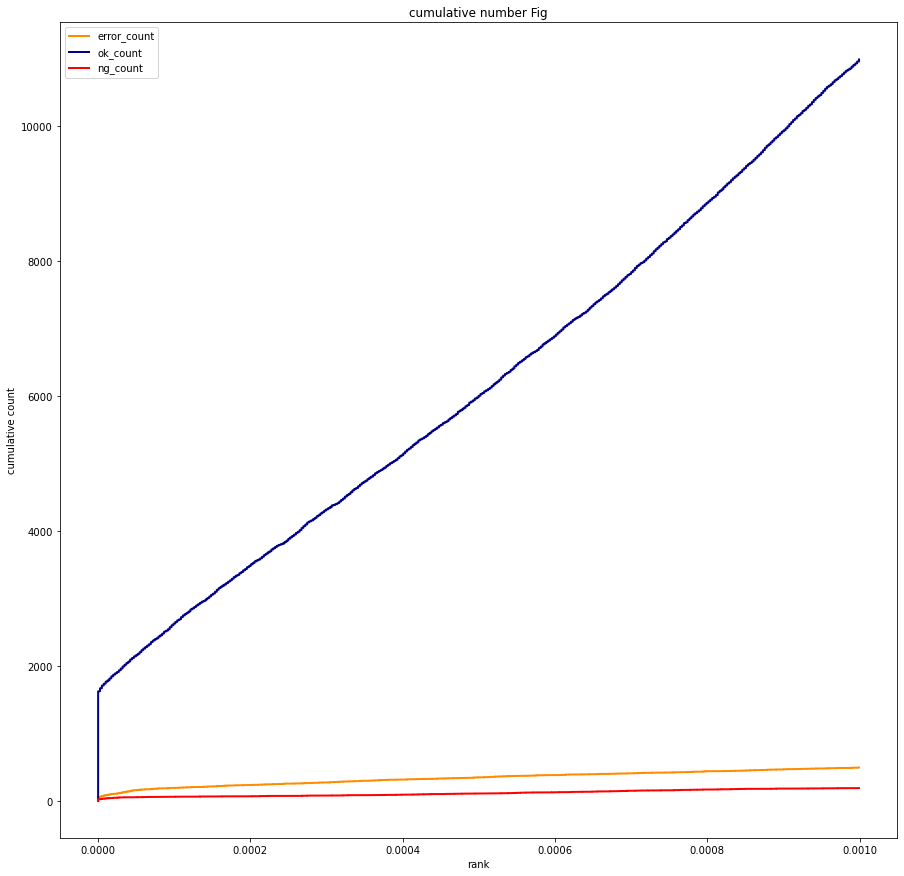

In [32]:
fig = plt.figure(figsize=(15, 15))
lw = 2 # 線的粗細
plt.plot(x, error_count, color='darkorange', lw=lw, label='error_count')
plt.plot(x, ok_count, color='darkblue', lw=lw, label='ok_count')
plt.plot(x, ng_count, color='red', lw=lw, label='ng_count')

plt.xlabel('rank')
plt.ylabel('cumulative count')
plt.title('cumulative number Fig')
plt.legend(loc="upper left")
#fig.savefig('/tmp/roc.png')
plt.show()